# Analytics Vidhya's Janatahack: Customer Segmentation Hackathon

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, classification_report
from collections import Counter
from sklearn.impute import KNNImputer

In [2]:
df_train = pd.read_csv('data/Train.csv', header=0)
df_test = pd.read_csv('data/Test.csv', header=0)
submission = pd.read_csv('data/sample_submission.csv', header=0)

In [3]:
print(df_train.shape, df_test.shape, submission.shape)

(8068, 11) (2627, 10) (2627, 2)


In [4]:
df_train.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [5]:
label_col = 'Segmentation'

In [6]:
df_test = pd.merge(df_test, df_train[['ID', label_col]], on='ID', how='left')

In [7]:
df_test.shape

(2627, 11)

In [8]:
df_test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,C
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,C
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,C


## Lookup labels from training data

If you look at train and test data you will find ID's which are common to both. In fact, 2332 out of 2627 (i.e. 88.77%!) are present in training data itself. You can just look-up label for these instead of using a model.

In [9]:
df_test, df_test_common = df_test[pd.isna(df_test[label_col])], df_test[pd.notna(df_test[label_col])]

In [10]:
print(df_test.shape, df_test_common.shape)

(295, 11) (2332, 11)


In [11]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
print(cat_cols)

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']


## Encode Categorical Variables

In [12]:
label_encoders = {}
for feature in cat_cols:
    if feature == label_col:
        le = preprocessing.LabelEncoder()
        le.fit(df_train.loc[pd.notna(df_train[feature]), feature].unique())
        label_encoders[feature] = le
    else:
        le = preprocessing.LabelEncoder()
        le.fit(pd.concat((df_train.loc[pd.notna(df_train[feature]), feature], df_test.loc[pd.notna(df_test[feature]), feature])).unique())
        label_encoders[feature] = le

In [13]:
missing_impute = -999

In [14]:
for feature in cat_cols:
    print(feature)
    if feature == label_col:
        df_train[feature] = label_encoders[feature].transform(df_train[feature])
    else:
        df_train[feature] = df_train[feature].apply(lambda x: x if pd.isna(x) else label_encoders[feature].transform([x])[0])
        df_test[feature] = df_test[feature].apply(lambda x: x if pd.isna(x) else label_encoders[feature].transform([x])[0])

Gender
Ever_Married
Graduated
Profession
Spending_Score
Var_1
Segmentation


In [15]:
cat_cols.remove(label_col)

In [16]:
print(cat_cols)

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


In [17]:
print(df_train.columns, df_test.columns)
print(df_train.shape, df_test.shape)

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object') Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')
(8068, 11) (295, 11)


In [18]:
df_train_test = pd.concat((df_train, df_test))
print(df_train_test.shape)

(8363, 11)


In [19]:
df_train_test.apply(lambda x: sum(pd.isna(x)), axis=0)

ID                   0
Gender               0
Ever_Married       144
Age                  0
Graduated           80
Profession         128
Work_Experience    857
Spending_Score       0
Family_Size        344
Var_1               80
Segmentation       295
dtype: int64

In [20]:
df_train_test.dtypes

ID                   int64
Gender               int64
Ever_Married       float64
Age                  int64
Graduated          float64
Profession         float64
Work_Experience    float64
Spending_Score       int64
Family_Size        float64
Var_1              float64
Segmentation        object
dtype: object

In [21]:
df_train_test['any_missing_flag'] = df_train_test.apply(lambda x: np.any(pd.isna(x)), axis=1).astype('int')

In [22]:
%%time
imputer = KNNImputer(n_neighbors=1, weights='distance')
df_train_test[['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']] = imputer.fit_transform(df_train_test[['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']])

CPU times: user 2.15 s, sys: 303 ms, total: 2.45 s
Wall time: 757 ms


In [23]:
df_train_test.apply(lambda x: sum(pd.isna(x)), axis=0)

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size           0
Var_1                 0
Segmentation        295
any_missing_flag      0
dtype: int64

In [24]:
df_train_test.dtypes

ID                    int64
Gender              float64
Ever_Married        float64
Age                 float64
Graduated           float64
Profession          float64
Work_Experience     float64
Spending_Score      float64
Family_Size         float64
Var_1               float64
Segmentation         object
any_missing_flag      int64
dtype: object

## Convert Variables Back to int

In [25]:
df_train_test['Gender'] = df_train_test['Gender'].apply(np.round).astype('int')
df_train_test['Ever_Married'] = df_train_test['Ever_Married'].apply(np.round).astype('int')
df_train_test['Graduated'] = df_train_test['Graduated'].apply(np.round).astype('int')
df_train_test['Age'] = df_train_test['Age'].apply(np.round).astype('int')
df_train_test['Profession'] = df_train_test['Profession'].apply(np.round).astype('int')
df_train_test['Work_Experience'] = df_train_test['Work_Experience'].apply(np.round).astype('int')
df_train_test['Spending_Score'] = df_train_test['Spending_Score'].apply(np.round).astype('int')
df_train_test['Family_Size'] = df_train_test['Family_Size'].apply(np.round).astype('int')
df_train_test['Var_1'] = df_train_test['Var_1'].apply(np.round).astype('int')

In [26]:
df_train_test.to_csv('data/df_train_test_imputed.csv', index=None)

## Feature engineering

Features by merging train and test data can be created only in a competition such as this :)

count based, unique counts, mean and std feature

In [27]:
# count features
df_train_test = pd.merge(df_train_test, df_train_test.groupby(['Gender', 'Ever_Married'])['Segmentation'].count().reset_index().rename(columns={'Segmentation': 'Gender_Ever_Married_Count'}), on=['Gender', 'Ever_Married'])

df_train_test = pd.merge(df_train_test, df_train_test.groupby(['Ever_Married', 'Graduated'])['Segmentation'].count().reset_index().rename(columns={'Segmentation': 'Ever_Married_Graduated_Count'}), on=['Ever_Married', 'Graduated'])

In [28]:
# unique counts
df_train_test['Gender_Unique_Professions']=df_train_test.groupby(['Gender'])['Profession'].transform('nunique')
df_train_test['Gender_Unique_Var_1']=df_train_test.groupby(['Gender'])['Var_1'].transform('nunique')

df_train_test['Graduated_Unique_Professions']=df_train_test.groupby(['Graduated'])['Profession'].transform('nunique')
df_train_test['Graduated_Unique_Var_1']=df_train_test.groupby(['Graduated'])['Var_1'].transform('nunique')

df_train_test['Ever_Married_Unique_Professions']=df_train_test.groupby(['Ever_Married'])['Profession'].transform('nunique')
df_train_test['Ever_Married_Unique_Var_1']=df_train_test.groupby(['Ever_Married'])['Var_1'].transform('nunique')

df_train_test['Gender_Unique_Professions']=df_train_test.groupby(['Gender'])['Profession'].transform('nunique')
df_train_test['Gender_Unique_Var_1']=df_train_test.groupby(['Gender'])['Var_1'].transform('nunique')


In [29]:
# mean features
df_train_test['Gender_Mean_Age']=df_train_test.groupby(['Gender'])['Age'].transform(np.nanmean)
df_train_test['Gender_Mean_Family_Size']=df_train_test.groupby(['Gender'])['Family_Size'].transform(np.nanmean)
df_train_test['Gender_Mean_Work_Experience']=df_train_test.groupby(['Gender'])['Work_Experience'].transform(np.nanmean)


df_train_test['Profession_Mean_Age']=df_train_test.groupby(['Profession'])['Age'].transform(np.nanmean)
df_train_test['Profession_Mean_Family_Size']=df_train_test.groupby(['Profession'])['Family_Size'].transform(np.nanmean)
df_train_test['Profession_Mean_Work_Experience']=df_train_test.groupby(['Profession'])['Work_Experience'].transform(np.nanmean)


df_train_test['Ever_Married_Mean_Age']=df_train_test.groupby(['Ever_Married'])['Age'].transform(np.nanmean)
df_train_test['Ever_Married_Mean_Family_Size']=df_train_test.groupby(['Ever_Married'])['Family_Size'].transform(np.nanmean)
df_train_test['Ever_Married_Mean_Work_Experience']=df_train_test.groupby(['Ever_Married'])['Work_Experience'].transform(np.nanmean)


df_train_test['Graduated_Mean_Age']=df_train_test.groupby(['Graduated'])['Age'].transform(np.nanmean)
df_train_test['Graduated_Mean_Family_Size']=df_train_test.groupby(['Graduated'])['Family_Size'].transform(np.nanmean)
df_train_test['Graduated_Mean_Work_Experience']=df_train_test.groupby(['Graduated'])['Work_Experience'].transform(np.nanmean)

In [30]:
# std features
df_train_test['Gender_Std_Age']=df_train_test.groupby(['Gender'])['Age'].transform(np.nanstd)
df_train_test['Gender_Std_Family_Size']=df_train_test.groupby(['Gender'])['Family_Size'].transform(np.nanstd)
df_train_test['Gender_Std_Work_Experience']=df_train_test.groupby(['Gender'])['Work_Experience'].transform(np.nanstd)


df_train_test['Profession_Std_Age']=df_train_test.groupby(['Profession'])['Age'].transform(np.nanstd)
df_train_test['Profession_Std_Family_Size']=df_train_test.groupby(['Profession'])['Family_Size'].transform(np.nanstd)
df_train_test['Profession_Std_Work_Experience']=df_train_test.groupby(['Profession'])['Work_Experience'].transform(np.nanstd)


df_train_test['Ever_Married_Std_Age']=df_train_test.groupby(['Ever_Married'])['Age'].transform(np.nanstd)
df_train_test['Ever_Married_Std_Family_Size']=df_train_test.groupby(['Ever_Married'])['Family_Size'].transform(np.nanstd)
df_train_test['Ever_Married_Std_Work_Experience']=df_train_test.groupby(['Ever_Married'])['Work_Experience'].transform(np.nanstd)


df_train_test['Graduated_Std_Age']=df_train_test.groupby(['Graduated'])['Age'].transform(np.nanstd)
df_train_test['Graduated_Std_Family_Size']=df_train_test.groupby(['Graduated'])['Family_Size'].transform(np.nanstd)
df_train_test['Graduated_Std_Work_Experience']=df_train_test.groupby(['Graduated'])['Work_Experience'].transform(np.nanstd)

In [31]:
df_train_test.shape

(8363, 44)

In [32]:
df_train, df_test = df_train_test[pd.notna(df_train_test[label_col])], df_train_test[pd.isna(df_train_test[label_col])]

In [33]:
print(df_train.columns, df_test.columns)
print(df_train.shape, df_test.shape)

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation', 'any_missing_flag', 'Gender_Ever_Married_Count',
       'Ever_Married_Graduated_Count', 'Gender_Unique_Professions',
       'Gender_Unique_Var_1', 'Graduated_Unique_Professions',
       'Graduated_Unique_Var_1', 'Ever_Married_Unique_Professions',
       'Ever_Married_Unique_Var_1', 'Gender_Mean_Age',
       'Gender_Mean_Family_Size', 'Gender_Mean_Work_Experience',
       'Profession_Mean_Age', 'Profession_Mean_Family_Size',
       'Profession_Mean_Work_Experience', 'Ever_Married_Mean_Age',
       'Ever_Married_Mean_Family_Size', 'Ever_Married_Mean_Work_Experience',
       'Graduated_Mean_Age', 'Graduated_Mean_Family_Size',
       'Graduated_Mean_Work_Experience', 'Gender_Std_Age',
       'Gender_Std_Family_Size', 'Gender_Std_Work_Experience',
       'Profession_Std_Age', 'Profession_Std_Family_Size',
       'Profession_Std_W

In [34]:
df_test.drop([label_col], axis=1, inplace=True)

/Users/abhay.shukla/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Impute Family_Size and Work_Experience

In [35]:
# df_train = df_train.fillna(missing_impute)
# df_test = df_test.fillna(missing_impute)

In [36]:
# Family_Size_Impute = np.nanmedian(df_train['Family_Size'].tolist() + df_test['Family_Size'].tolist())
# Work_Experience_Impute = np.nanmedian(df_train['Work_Experience'].tolist() + df_test['Work_Experience'].tolist())

# df_train['Family_Size'] = df_train['Family_Size'].fillna(Family_Size_Impute)
# df_test['Family_Size'] = df_test['Family_Size'].fillna(Family_Size_Impute)

# df_train['Work_Experience'] = df_train['Work_Experience'].fillna(Work_Experience_Impute)
# df_test['Work_Experience'] = df_test['Work_Experience'].fillna(Work_Experience_Impute)

## Define Stratification Strategy

In [37]:
stratify_key = df_train['Segmentation']

## Add dummfyied versions of categorical variables as well

In [38]:
df_train_dum = pd.get_dummies(df_train[cat_cols], columns=cat_cols)
df_test_dum = pd.get_dummies(df_test[cat_cols], columns=cat_cols)

df_train = pd.concat([df_train, df_train_dum], axis=1)
df_test = pd.concat([df_test, df_test_dum], axis=1)

In [39]:
df_train[label_col] = df_train[label_col].astype('int')

## Train, Eval Split

In [40]:
df_train, df_eval = train_test_split(df_train, test_size=0.25, random_state=42, shuffle=True, stratify=stratify_key)

In [41]:
print(df_train.shape, df_eval.shape)

(6051, 69) (2017, 69)


In [42]:
df_train.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation', 'any_missing_flag', 'Gender_Ever_Married_Count',
       'Ever_Married_Graduated_Count', 'Gender_Unique_Professions',
       'Gender_Unique_Var_1', 'Graduated_Unique_Professions',
       'Graduated_Unique_Var_1', 'Ever_Married_Unique_Professions',
       'Ever_Married_Unique_Var_1', 'Gender_Mean_Age',
       'Gender_Mean_Family_Size', 'Gender_Mean_Work_Experience',
       'Profession_Mean_Age', 'Profession_Mean_Family_Size',
       'Profession_Mean_Work_Experience', 'Ever_Married_Mean_Age',
       'Ever_Married_Mean_Family_Size', 'Ever_Married_Mean_Work_Experience',
       'Graduated_Mean_Age', 'Graduated_Mean_Family_Size',
       'Graduated_Mean_Work_Experience', 'Gender_Std_Age',
       'Gender_Std_Family_Size', 'Gender_Std_Work_Experience',
       'Profession_Std_Age', 'Profession_Std_Family_Size',
       'Profession_Std_W

## Select Feature Columns

In [43]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove(label_col)
print(feature_cols)

['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'any_missing_flag', 'Gender_Ever_Married_Count', 'Ever_Married_Graduated_Count', 'Gender_Unique_Professions', 'Gender_Unique_Var_1', 'Graduated_Unique_Professions', 'Graduated_Unique_Var_1', 'Ever_Married_Unique_Professions', 'Ever_Married_Unique_Var_1', 'Gender_Mean_Age', 'Gender_Mean_Family_Size', 'Gender_Mean_Work_Experience', 'Profession_Mean_Age', 'Profession_Mean_Family_Size', 'Profession_Mean_Work_Experience', 'Ever_Married_Mean_Age', 'Ever_Married_Mean_Family_Size', 'Ever_Married_Mean_Work_Experience', 'Graduated_Mean_Age', 'Graduated_Mean_Family_Size', 'Graduated_Mean_Work_Experience', 'Gender_Std_Age', 'Gender_Std_Family_Size', 'Gender_Std_Work_Experience', 'Profession_Std_Age', 'Profession_Std_Family_Size', 'Profession_Std_Work_Experience', 'Ever_Married_Std_Age', 'Ever_Married_Std_Family_Size', 'Ever_Married_Std_Work_Experience', 'Graduated_Std_Age', 'Gr

In [44]:
df_train[label_col].value_counts()

3    1701
0    1479
2    1478
1    1393
Name: Segmentation, dtype: int64

In [45]:
df_eval[label_col].value_counts()

3    567
0    493
2    492
1    465
Name: Segmentation, dtype: int64

## Hyperparameters

In [46]:
params = {
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_data_in_leaf': 19, 
    'n_estimators': 376, 
    'reg_alpha': 1.05, 
    'reg_lambda': 2.53, 
    'objective': 'multiclass', 
    'boosting_type': 'gbdt', 
    'subsample': 0.7, 
    'random_state': 42, 
    'colsample_bytree': 0.7, 
    'class_weight': {0: 0.38, 1: 0.29, 2: 0.27, 3: 0.34}
}

## Model Training and Evaluation

In [47]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=400, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature='')

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

/Users/abhay.shukla/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.649314	valid_0's multi_logloss: 1.37647	valid_1's multi_error: 0.650471	valid_1's multi_logloss: 1.37613
Training until validation scores don't improve for 400 rounds
[2]	valid_0's multi_error: 0.631796	valid_0's multi_logloss: 1.36135	valid_1's multi_error: 0.630144	valid_1's multi_logloss: 1.36052
[3]	valid_0's multi_error: 0.609817	valid_0's multi_logloss: 1.3464	valid_1's multi_error: 0.606346	valid_1's multi_logloss: 1.34552
[4]	valid_0's multi_error: 0.60866	valid_0's multi_logloss: 1.33309	valid_1's multi_error: 0.607833	valid_1's multi_logloss: 1.33183
[5]	valid_0's multi_error: 0.60899	valid_0's multi_logloss: 1.32052	valid_1's multi_error: 0.608825	valid_1's multi_logloss: 1.31906
[6]	valid_0's multi_error: 0.560899	valid_0's multi_logloss: 1.30893	valid_1's multi_error: 0.551314	valid_1's multi_logloss: 1.30726
[7]	valid_0's multi_error: 0.533135	valid_0's multi_logloss: 1.29867	valid_1's multi_error: 0.523054	valid_1's multi_logloss: 1.29641
[8]

[70]	valid_0's multi_error: 0.471492	valid_0's multi_logloss: 1.08386	valid_1's multi_error: 0.460585	valid_1's multi_logloss: 1.08233
[71]	valid_0's multi_error: 0.471162	valid_0's multi_logloss: 1.08289	valid_1's multi_error: 0.459593	valid_1's multi_logloss: 1.08147
[72]	valid_0's multi_error: 0.470831	valid_0's multi_logloss: 1.08182	valid_1's multi_error: 0.459098	valid_1's multi_logloss: 1.08057
[73]	valid_0's multi_error: 0.470005	valid_0's multi_logloss: 1.08078	valid_1's multi_error: 0.459593	valid_1's multi_logloss: 1.07963
[74]	valid_0's multi_error: 0.470005	valid_0's multi_logloss: 1.07974	valid_1's multi_error: 0.459593	valid_1's multi_logloss: 1.07865
[75]	valid_0's multi_error: 0.468683	valid_0's multi_logloss: 1.0788	valid_1's multi_error: 0.457115	valid_1's multi_logloss: 1.07782
[76]	valid_0's multi_error: 0.469013	valid_0's multi_logloss: 1.07798	valid_1's multi_error: 0.456619	valid_1's multi_logloss: 1.07715
[77]	valid_0's multi_error: 0.467857	valid_0's multi_log

[156]	valid_0's multi_error: 0.447199	valid_0's multi_logloss: 1.03626	valid_1's multi_error: 0.458602	valid_1's multi_logloss: 1.04695
[157]	valid_0's multi_error: 0.447695	valid_0's multi_logloss: 1.03598	valid_1's multi_error: 0.459593	valid_1's multi_logloss: 1.04674
[158]	valid_0's multi_error: 0.446703	valid_0's multi_logloss: 1.03566	valid_1's multi_error: 0.460089	valid_1's multi_logloss: 1.0466
[159]	valid_0's multi_error: 0.446703	valid_0's multi_logloss: 1.03538	valid_1's multi_error: 0.460585	valid_1's multi_logloss: 1.04633
[160]	valid_0's multi_error: 0.446538	valid_0's multi_logloss: 1.03504	valid_1's multi_error: 0.460585	valid_1's multi_logloss: 1.04618
[161]	valid_0's multi_error: 0.446207	valid_0's multi_logloss: 1.03477	valid_1's multi_error: 0.460585	valid_1's multi_logloss: 1.04613
[162]	valid_0's multi_error: 0.446207	valid_0's multi_logloss: 1.03449	valid_1's multi_error: 0.460585	valid_1's multi_logloss: 1.04608
[163]	valid_0's multi_error: 0.445877	valid_0's m

[243]	valid_0's multi_error: 0.436787	valid_0's multi_logloss: 1.01458	valid_1's multi_error: 0.460089	valid_1's multi_logloss: 1.03711
[244]	valid_0's multi_error: 0.436787	valid_0's multi_logloss: 1.0144	valid_1's multi_error: 0.460089	valid_1's multi_logloss: 1.03697
[245]	valid_0's multi_error: 0.436787	valid_0's multi_logloss: 1.0142	valid_1's multi_error: 0.459098	valid_1's multi_logloss: 1.03686
[246]	valid_0's multi_error: 0.436622	valid_0's multi_logloss: 1.01404	valid_1's multi_error: 0.459098	valid_1's multi_logloss: 1.03674
[247]	valid_0's multi_error: 0.436126	valid_0's multi_logloss: 1.01389	valid_1's multi_error: 0.459098	valid_1's multi_logloss: 1.03666
[248]	valid_0's multi_error: 0.436126	valid_0's multi_logloss: 1.01369	valid_1's multi_error: 0.459098	valid_1's multi_logloss: 1.03652
[249]	valid_0's multi_error: 0.436292	valid_0's multi_logloss: 1.01352	valid_1's multi_error: 0.458602	valid_1's multi_logloss: 1.03653
[250]	valid_0's multi_error: 0.436126	valid_0's mu

[324]	valid_0's multi_error: 0.431664	valid_0's multi_logloss: 1.00201	valid_1's multi_error: 0.453644	valid_1's multi_logloss: 1.03331
[325]	valid_0's multi_error: 0.431499	valid_0's multi_logloss: 1.0019	valid_1's multi_error: 0.453644	valid_1's multi_logloss: 1.03329
[326]	valid_0's multi_error: 0.431664	valid_0's multi_logloss: 1.00175	valid_1's multi_error: 0.454636	valid_1's multi_logloss: 1.03328
[327]	valid_0's multi_error: 0.431168	valid_0's multi_logloss: 1.00165	valid_1's multi_error: 0.454636	valid_1's multi_logloss: 1.03324
[328]	valid_0's multi_error: 0.431003	valid_0's multi_logloss: 1.00149	valid_1's multi_error: 0.453644	valid_1's multi_logloss: 1.03317
[329]	valid_0's multi_error: 0.430838	valid_0's multi_logloss: 1.00136	valid_1's multi_error: 0.453148	valid_1's multi_logloss: 1.03318
[330]	valid_0's multi_error: 0.430838	valid_0's multi_logloss: 1.00125	valid_1's multi_error: 0.453644	valid_1's multi_logloss: 1.03316
[331]	valid_0's multi_error: 0.431003	valid_0's m

In [48]:
print('Eval ACC: {}'.format(eval_score))

Eval ACC: 0.5463559742191373


## Train Model on Full Data

In [49]:
df_train = pd.concat((df_train, df_eval))

In [50]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature='')

eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.5707734258800198


## Predictions

In [51]:
preds = clf.predict(df_test[feature_cols]).astype('int')
preds = label_encoders[label_col].inverse_transform(preds)

In [52]:
Counter(preds)

Counter({'A': 101, 'D': 104, 'B': 40, 'C': 50})

In [53]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Segmentation':preds})
submission = pd.concat((submission, df_test_common[['ID', 'Segmentation']]))
submission = submission.sort_values('ID')

In [54]:
submission.shape

(2627, 2)

In [55]:
submission.to_csv('lgb_baseline.csv', index=None)

## Feature Importance

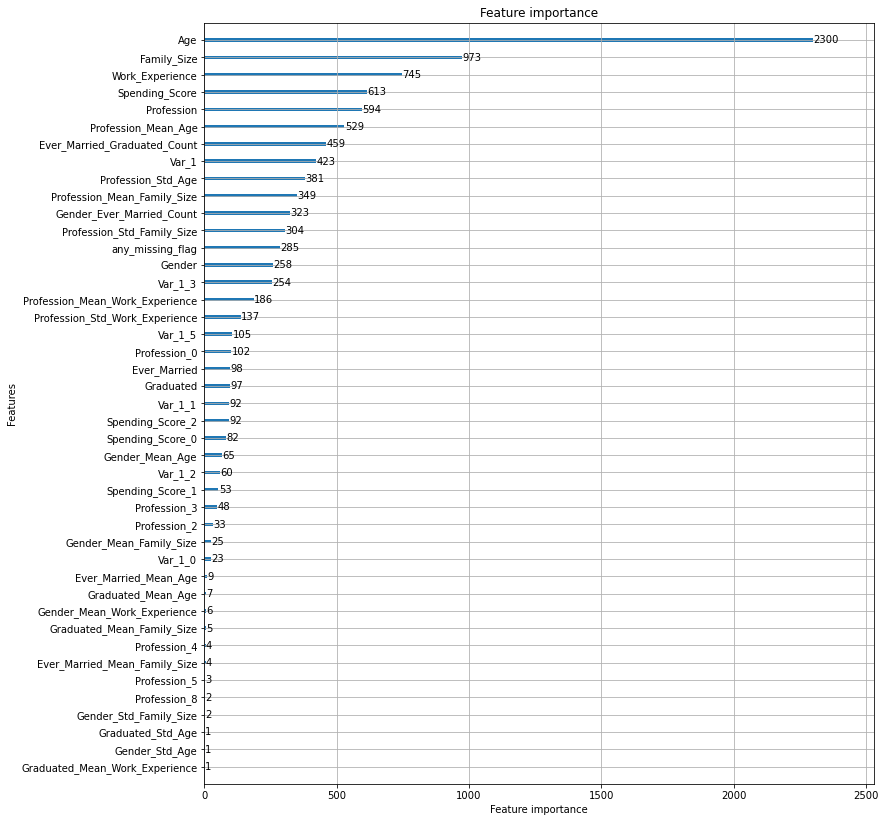

In [56]:
plt.rcParams['figure.figsize'] = (12, 14)
lgb.plot_importance(clf)
plt.show()

## Adding Few more Iterations Improved the Public LB Score - can cause overfitting on Public LB Score

In [57]:
params = {
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_data_in_leaf': 19, 
    'n_estimators': 432, 
    'reg_alpha': 1.05, 
    'reg_lambda': 2.53,
    'objective': 'multiclass', 
    'boosting_type': 'gbdt', 
    'subsample': 0.7, 
    'random_state': 42, 
    'colsample_bytree': 0.7, 
    'class_weight': {0: 0.38, 1: 0.29, 2: 0.27, 3: 0.34}
}

print(params)

{'learning_rate': 0.05, 'max_depth': 3, 'min_data_in_leaf': 19, 'n_estimators': 432, 'reg_alpha': 1.05, 'reg_lambda': 2.53, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'class_weight': {0: 0.38, 1: 0.29, 2: 0.27, 3: 0.34}}


In [58]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature='')
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.5736241943480417


In [59]:
preds = clf.predict(df_test[feature_cols]).astype('int')
preds = label_encoders[label_col].inverse_transform(preds)

In [60]:
Counter(preds)

Counter({'A': 99, 'D': 103, 'B': 43, 'C': 50})

In [61]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Segmentation':preds})
submission = pd.concat((submission, df_test_common[['ID', 'Segmentation']]))
submission = submission.sort_values('ID')
submission.to_csv('lgb_final_submission.csv', index=None)